Machine learning partie 1 <b>Supervisé</b>:
    
   - I - <b>Splitting data</b>
    
   - II - <b>training models</b>
    
   - III - <b>Learning curves & validation</b>
    
   - IV - <b>Fine tuning</b>
    
   - V - <b>Classification metrics</b>
   
   - VI - <b>final test</b>


In [1]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt

sns.set_theme(style="darkgrid")

In [2]:
data = pd.read_csv('/Users/lucas/Desktop/Polytech/IG4/S7/projet_DS/mail_pre_process.csv')
df = data[['DayWeek','Cat_1_level_1',
       'Cat_1_level_2', 'Cat_1_weight','Years', 'Month', 'Day', 'Hours',
       'content_char_len', 'content_char_length_category',  'To_count']]

class_mapping = {1999: 0, 2000: 1, 2001: 2, 2002: 3}

df = df.replace({'Years':class_mapping})

In [3]:
print(df.shape)
df.head()

(99913, 11)


,DayWeek,Cat_1_level_1,Cat_1_level_2,Cat_1_weight,Years,Month,Day,Hours,content_char_len,content_char_length_category,To_count
0,0,-1,-1,-1,2,5,14,23,20,1,1
1,4,-1,-1,-1,2,5,4,20,773,2,1
2,2,-1,-1,-1,1,10,18,10,29,1,1
3,0,-1,-1,-1,1,10,23,13,180,1,1
4,3,-1,-1,-1,1,8,31,12,33,1,1


In [4]:
df.columns

Index(['DayWeek', 'Cat_1_level_1', 'Cat_1_level_2', 'Cat_1_weight', 'Years',
       'Month', 'Day', 'Hours', 'content_char_len',
       'content_char_length_category', 'To_count'],
      dtype='object')

<center><h1>Partie 1 - supervisée.</h1></center>

Après avoir préparé et exploré nos données, nous devons choisir un algorithme performant pour pouvoir effectuer une classification efficace. Cependant, une classification efficace, n'est pas la seule caractéristiques à prendre en compte.

Il existe des compromis entre plusieurs caractéristiques des algorithmes:

- Vitesse d'entraînement.
- Utilisation de la mémoire.
- Précision prédictive sur les nouvelles données.
- Transparence ou inteprétabilité.

Il n'existe pas de meilleur modèle, certains seront très performant dans un cas d'utilisation mais parfois peu performant dans d'autre cas d'utilisation. Nous allons utiliser plusieurs modèles, les comparer puis en sélectionner un nombre restreint puis les comparer à nouveau, et ce jusqu'à avoir un (ou plusieurs) modèle convenable.

<center><h1>0 - Rappel sur la variable 'Years' de classification</h1></center>

2    53758
1    40012
3     5127
0     1016
Name: Years, dtype: int64


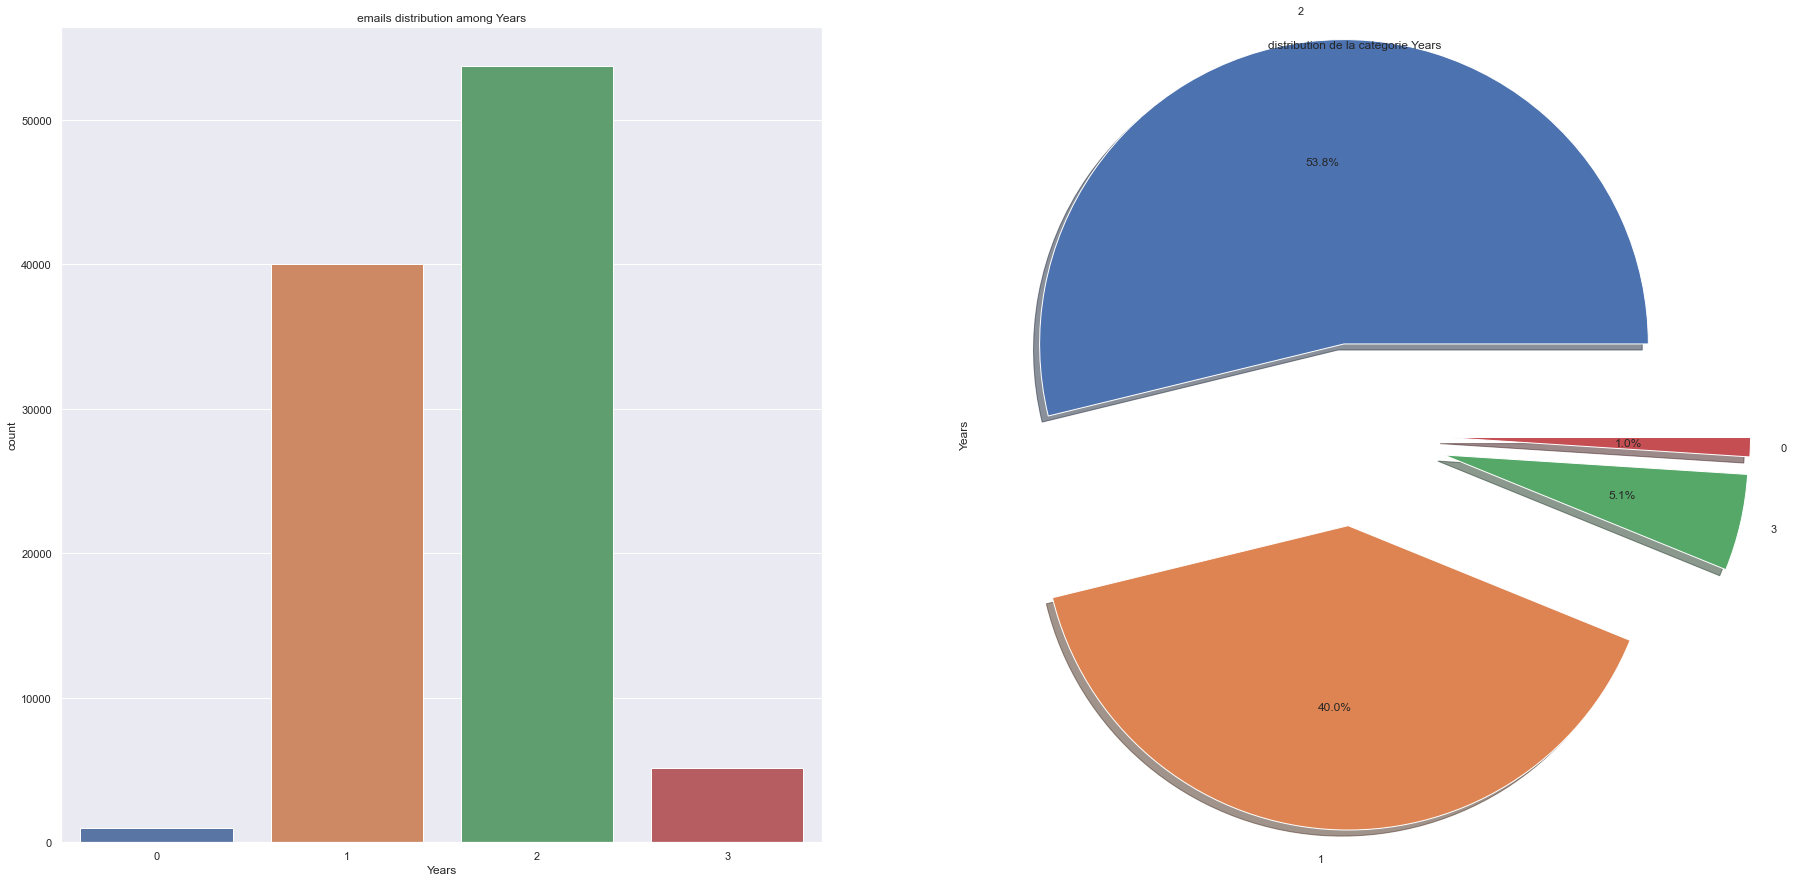

In [5]:
fig, (ax1,ax2) = plt.subplots(1,2, figsize=(30,15))
print(df['Years'].value_counts())
sns.countplot(x='Years', data=df, ax=ax1)
ax1.set_title('emails distribution among Years')

df['Years'].value_counts().plot.pie(explode=[0.3,0.3,0.3,0.3],autopct='%1.1f%%',ax=ax2,shadow=True)
ax2.set_title('distribution de la categorie Years')
plt.show()

La <b>distribution des classes</b> est tès importante lorsqu'on fait une classification.

- L'année <b>1999</b> représente <b>1%</b> des mails.
- L'année <b>2000</b> représente <b>40%</b> des mails.
- L'année <b>2001</b> représente <b>53,8%</b> des mails.
- L'année <b>2002</b> représente <b>5,1%</b> des mails.

Les années <b>1999 et 2002</b> sont sous représentées par rapport aux années <b>2000 et 2001</b>, nous sommes en présence de ce que l'on appelle un <b>Imbalanced dataset</b>. Si nous ne prenons pas en compte ce cas particulier, nos modèles risque d'<b>ignorer les classes minoritaires</b>. On pourrait alors avoir une <b>bonne précision générale</b>, mais une <b>mauvaise précision de classification au sein des classes</b>.


<center><h1>I - Data Preparation</h1></center>

<center><h3> a - Imbalanced dataset</h3></center>

Le défi de travailler avec des ensembles de données <b>déséquilibrés</b> (Imbalanced) est que la plupart des techniques de ML <b>ignoreront</b> la (ou les) classe minoriaire, et auront à leur tour des <b>performances médiocres sur la (ou les) classe minoritaire</b>, bien que ce soit généralement la performance sur la classe minoritaire qui soit la plus importante.

Une approche pour traiter les ensembles de données déséquilibrés consiste à <b>suréchantillonner</b> (oversample) la (ou les) classe(s) minoritaire(s):

- L’approche la plus simple consiste à <b>dupliquer des exemples</b> dans la classe minoritaire, bien que ces exemples n’ajoutent aucune nouvelle information au modèle. 

- Au lieu de cela, de <b>nouveaux exemples</b> peuvent être <b>synthétisés</b> à partir des <b>exemples existants</b>. Il s'agit d'un type d'augmentation des données pour la (les) classe(s) minoritaire(s) et est appelé <b>Synthetic Minority Oversampling TEchnique</b>, ou <b>SMOTE</b> en abrégé.

- Comment marche <b>SMOTE</b>?

   - SMOTE fonctionne en sélectionnant des exemples qui sont <b>proches</b> dans l'<b>espace des variables</b>, en traçant une ligne entre les exemples dans l'espace des variables et en dessinant un <b>nouvel échantillon</b> à un point le long de cette ligne.
   - Plus précisément, un <b>exemple aléatoire</b> de la classe minoritaire est d'abord choisi. On trouve alors <b>k des voisins les plus proches</b>. Un voisin <b>sélectionné au hasard</b> est choisi et un <b>exemple synthétique</b> est créé à un point sélectionné au hasard <b>entre les deux exemples</b> dans l'<b>espace des variables</b>.
   
   
- Cette procédure peut être utilisée pour créer autant d'exemples synthétiques pour la classe minoritaire que nécessaire. Comme décrit dans l'article, il suggère d'utiliser d'abord le <b>sous-échantillonnage aléatoire</b> (random undersampling)  pour réduire le nombre d'exemples dans la classe majoritaire, puis d'utiliser SMOTE pour <b>suréchantillonner</b> la classe minoritaire afin d'<b>équilibrer</b> la distribution de classe.

- On pourrait penser qu'il suffit d'effectuer ces méthodes sur le dataset une fois, avant de l'utiliser dans nos modèle. Cependant, ce n'est pas ce que nous allons faire, car cela peut poser énormément de problème notamment lors de la <b>validation</b>. Nous allons expliquer notre méthodologie en utilisant <b>SMOTE</b> au fur et à mesure.

In [15]:
from imblearn.over_sampling import SMOTE
from imblearn.under_sampling import RandomUnderSampler
from collections import Counter
from sklearn.model_selection import RepeatedStratifiedKFold

<br>
<center><h3>b - splitting data.</h3></center>

Tout d'abord, nous devons séparer nos données en 2:

- le <b>train set</b>: le jeu de données qui servira d'<b>entraînement</b> à nos modèles.
- le <b>test set</b>: le jeu de données <b>final</b> (ou final test) qui devrait servir à faire notre choix final entre tous les modèles (ou aucun).

Ensuite nous allons séparer le <b> train set</b> en 2:

- Le <b>train set</b> (ou sub-train set): le jeu de données qui servira d'<b>exemple</b> à nos modèles.
- Le <b>validation set</b>: le jeu de données qui servira à <b>tester</b> (ou valider) les performances de nos modèles.


Avant de séparer nos données, nous allons standardiser les variables en soutrayant la moyenne et en mettant à l'échelle la variance unitaire. Standardiser les données peut permettre à certains modèles de converger beaucoup plus vite.

In [6]:
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler

In [7]:
X = df.drop(columns=['Years'])
y = df['Years']
print(X.columns)
scaler = StandardScaler()
X = scaler.fit_transform(X)

Index(['DayWeek', 'Cat_1_level_1', 'Cat_1_level_2', 'Cat_1_weight', 'Month',
       'Day', 'Hours', 'content_char_len', 'content_char_length_category',
       'To_count'],
      dtype='object')


In [8]:
X_train_origin, X_final_test, y_train_origin, y_final_test = train_test_split(X, y, test_size=0.2, random_state=42)
X_train, X_test, y_train, y_test =  train_test_split(X_train_origin, y_train_origin, test_size=0.1, random_state=42)

In [9]:
print('train set size: ' ,len(X_train))
print('validation set size: ', len(X_test))
print('final test set size: ', len(X_final_test))


train set size:  71937
validation set size:  7993
final test set size:  19983


<br>
La fonction suivante va nous permettre de choisir la distribution des données voulu lors de l'<b>oversampling et undersampling</b>.
Avec ces méthodes, on peut choisir la distribution des données pour chaque classe. Nous allons donc <b>oversample</b> les classes 0 et 3 (classe 1999 et 2002) et <b>undersample</b> les classes 1 et 2 (classes 2000 et 2001)

In [36]:
def over_undersample(X, valid=False):
    if valid:
        len_1999 = round(len(X)/20)
        len_2000 = round(len(X)/20)*2
        len_2001 = round(len(X)/20)*2
        len_2002 = round(len(X)/20)
    else:
        len_1999 = round(len(X)/5)
        len_2000 = round((len(X)/5))*2
        len_2001 = round((len(X)/5))*2
        len_2002 = round(len(X)/5)
    return(len_1999, len_2000, len_2001, len_2002)

#Resample for training
len_1999, len_2000, len_2001, len_2002 = over_undersample(X_train)

oversample_train = SMOTE(sampling_strategy={0:len_1999,3:len_2002})
undersample_train = RandomUnderSampler(sampling_strategy={1:len_2000,2:len_2001})


#Resample for cross validation
len_1999, len_2000, len_2001, len_2002 = over_undersample(X_train_origin, True)

oversample_train_origin = SMOTE(sampling_strategy={0:len_1999,3:len_2002})
undersample_train_origin = RandomUnderSampler(sampling_strategy={1:len_2000,2:len_2001})



<br>
<center><h1> II - Model building</h1></center>

C'est le moment de pré-choisir nos modèles, il existe beaucoup de classifier:

- Decision Tree Classifier

- K nearest neighbors 

- Support Vector Machine --> L'entraînement SVM avec des noyaux non linéaires, qui est par défaut dans SVC de sklearn, est approximativement en termes de complexité: O<b>(n_samples ^ 2 * n_features)</b>. On s'en passera donc ici.

- Random Forest Classifier

- ... il en existe énormément.


Dans <b>notre cas</b>, nous allons utiliser les suivants:

- <b>Decision Tree Classifier</b>

- <b>Random Forest Classifier</b>

- <b>Logistic Regression</b>

- <b>Perceptron</b>

- <b> K nearest neighbors </b>

- <b>Ensemble Learning</b> (Boosting, Bagging)

- <b>Xgboost</b>

- <b>MLP Sequential</b>



Nous essaierons de les expliquer pas à pas.

In [11]:
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.linear_model import Perceptron
from sklearn.ensemble import AdaBoostClassifier
from xgboost import XGBClassifier

from imblearn.pipeline import make_pipeline as imbalanced_make_pipeline

from sklearn.model_selection import cross_val_score
from sklearn.metrics import confusion_matrix, accuracy_score, precision_score, recall_score, f1_score, balanced_accuracy_score

models = []
acc_training = []
acc_test = []
acc_balanced = []

<br>
<center><h3> a - Decision Tree Classifier </h3></center>

L'objectif est de créer un modèle qui prédit la valeur d'une variable cible (y) en apprenant des <b>règles de décision simples</b> déduites des caractéristiques (X) des données.

Il y a plusieurs <b>avantages</b> à utiliser les arbres de décision sont les suivants:

- Simple à comprendre et à interpréter. Les arbres peuvent être visualisés.

- Le coût d'utilisation de l'arbre (c'est-à-dire la prédiction des données) est <b>logarithmique</b> dans le nombre de points de données utilisés pour entraîner l'arbre.

- Utilise un modèle de boîte blanche. Si une situation donnée est observable dans un modèle, l'explication de la condition est facilement expliquée par la logique booléenne. En revanche, dans un modèle de boîte noire (par exemple, dans un réseau de neurones artificiels), les résultats peuvent être plus difficiles à interpréter.

Cependant, il y a aussi des <b>désavantages</b>:

- Les <b>Decision Tree learners</b> peuvent créer des arbres trop complexes qui ne <b>généralisent</b> pas bien les données. C'est ce qu'on appelle l'<b>overfitting</b>. Des mécanismes tels que l'<b>élagage</b>, la définition du nombre <b>minimum d'échantillons</b> requis au niveau d'un nœud feuille ou la définition de la <b>profondeur maximale</b> de l'arbre sont nécessaires pour éviter ce problème.

- Les Decision Tree learners créent des arbres biaisés si certaines classes <b>prédominent</b>. Il est donc recommandé d'équilibrer l'ensemble de données avant de le fit à l'arbre de décision.

Decision Tree training score:  0.9899773412847352
Decision Tree accuracy validation score:  0.9399474540222695
Decision Tree balanced accuracy validation score:  0.9205620733654318


<AxesSubplot:>

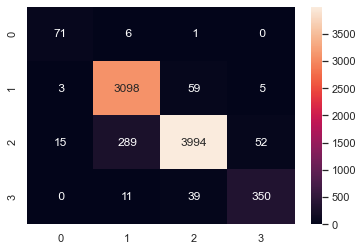

In [15]:
dtc = DecisionTreeClassifier()
pipeline_dtc = imbalanced_make_pipeline(oversample_train, undersample_train, dtc)

pipeline_dtc.fit(X_train, y_train)
y_pred = pipeline_dtc.predict(X_test)

training_score = pipeline_dtc.score(X_train,y_train)
test_score = accuracy_score(y_pred, y_test)
print('Decision Tree training score: ', training_score)
print('Decision Tree accuracy validation score: ', test_score)

balanced_score = balanced_accuracy_score(y_test, y_pred)
print('Decision Tree balanced accuracy validation score: ', balanced_score)
matrix = confusion_matrix(y_test, y_pred)
sns.heatmap(matrix, annot=True, fmt='2.0f')



In [16]:
models.append('DecisionTreeClassifier')
acc_training.append(training_score)
acc_test.append(test_score)
acc_balanced.append(balanced_score)

<br>
<center><h3>b - Random Forest Classifier</h3></center>

Une <b>Random Forest</b> est un ensemble de <b>Decision Tree</b> généralement via une méthode de <b>bagging</b>. A quelques exceptions près, une Random Forest Classifier possède les mêmes <b>hyperparamètres</b> qu'un Decision Tree Classifier (Pour controler comment les abres grandissent), plus tous les <b>hyperparamètres</b> d'un <b>Bagging Classifier</b>. (explications: *Bagging methods*: Annexe ML, *hyperparamètres*: Annexe ML)

l'algorithme de Random Forest introduit un <b>caractère aléatoire</b> supplémentaire lors de la croissance des arbres. Plus précisemment, il recherche la meilleure caractéristique parmi un <b>sous-ensemble aléatoire</b> de caractéristiques.

Cet algorithme résulte donc en une très <b>grande diversité</b> d'arbre, ce qui donne lieu à un <b>grand biais</b> pour une <b>faible variable</b>, ce la donne généralement un <b>meilleur modèle global<b>.
    
Une <b>grande qualité</b> des Random Forest est qu'elles rendent facile <b>la mesure de l'importance relative</b> de chaque variable. Sklearn mesure l'importance d'une variable en regardant comment les noeuds des arbres qui utilisent cette variable réduisent en moyenne l'impureté. 
Plus précisement, c'est une <b>moyenne pondérée</b>, où chaque <b>poids</b> d'un noeud est égale au nombre d'<b>échantillons</b> d'entraînement qui y est associé.

Random Forest training score:  0.9903665707494057
Random Forest validation score:  0.9459527086200425
RandomForest balanced accuracy validation score:  0.9004095534715326


<AxesSubplot:>

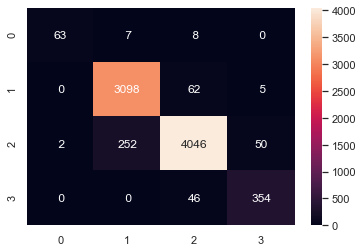

In [17]:
rfc = RandomForestClassifier()
pipeline_rfc = imbalanced_make_pipeline(oversample_train, undersample_train, rfc)


pipeline_rfc.fit(X_train, y_train)
y_pred = pipeline_rfc.predict(X_test)

training_score = pipeline_rfc.score(X_train,y_train)
test_score = accuracy_score(y_pred, y_test)
print('Random Forest training score: ', training_score)
print('Random Forest validation score: ', test_score)

balanced_score = balanced_accuracy_score(y_test, y_pred)
print('RandomForest balanced accuracy validation score: ', balanced_score)

matrix = confusion_matrix(y_test, y_pred)
sns.heatmap(matrix, annot=True, fmt='2.0f')

In [18]:
models.append('RandomForestClassifier')
acc_training.append(training_score)
acc_test.append(test_score)
acc_balanced.append(balanced_score)

<br>
<center><h3>c - Logistic Regression</h3></center>



<b>Logistic Regression</b> est souvent utilisé pour estimer la <b>probabilité</b> qu'une instance fasse partie d'une classe particulière. 
Si la <b>probabilité estimée</b> est plus grande que 50%, alors le modèle prédit que l'instance fait partie de cette classe (la classe <b>positive</b>) et sinon le modèle prédit que l'instance ne fait pas partie de cette classe (mais de la classe <b>négative</b>). Cela en fait donc un <b>classifier binaire</b>, ce qui n'est pas ce que l'on veut.



En fait, ce modèle peut aussi être appliqué à des problèmes <b>multiclasses</b>, le modèle s'appelle alors <b>Multinomial Logistic Regression</b>. Cependant, le modèle multinomial de la logistic regression est particulièrement important pour des modèles sophistiqués utilisés en <b>deep learning</b>.

La Logistic Regression est également intéressante car nous prenons nos variables d'entrées, les transformons via une <b>combinaison linéaire</b> des poids(weights) (à savoir A1 · X1 + A2 · X2 + A3 · X3 ...), puis les exécutons via une fonction <b>non linéaire</b>.

Soit <b>F</b> la fonction reprensentant l'<b>estimation</b> de probabilité la <b>probabilité totale</b> d'un jeu de données est:

$Probability = \prod_{n=1}^{n}(F(X_i))^{y_i}.(1-F(X_i))^{1-y_i} $

L'objectif sera alors de <b>maximiser</b> cette probabilité. On peut le faire en prenant la <b>dérivée</b> par rapport à nos poids (weights) en définissant la dérivée à 0. Nous pouvons ensuite exécuter une <b>descente de gradient</b> en utilisant notre gradient calculé pour obtenir nos poids optimaux.

le modèle de Logistic Regression a une description assez simple, peut être entraîné assez rapidement grâce à des techniques telles que la descente de gradient en raison de sa  dérivée, et fonctionne souvent bien dans la pratique.

Logistic Regression training score:  0.5748363151090538
Logistic Regression validation score:  0.5798823970974603
LogisticRegression balanced accuracy validation score:  0.5151728668795387


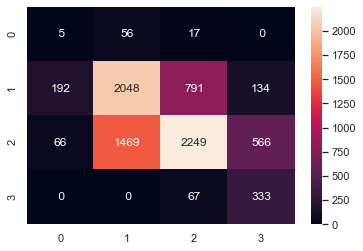

In [19]:
lg = LogisticRegression(max_iter=300)
pipeline_lg = imbalanced_make_pipeline(oversample_train, undersample_train, lg)

pipeline_lg.fit(X_train, y_train)
y_pred = pipeline_lg.predict(X_test)
training_score = pipeline_lg.score(X_train,y_train)
test_score = accuracy_score(y_pred, y_test)
print('Logistic Regression training score: ', training_score)
print('Logistic Regression validation score: ', test_score)


balanced_score = balanced_accuracy_score(y_test, y_pred)
print('LogisticRegression balanced accuracy validation score: ', balanced_score)

matrix = confusion_matrix(y_test, y_pred)
sns.heatmap(matrix, annot=True, fmt='2.0f')
acc_balanced.append(balanced_score)

In [20]:
models.append('Logistic Regression')
acc_training.append(training_score)
acc_test.append(test_score)


<center><h3>d - KNearestNeighbours</h3></center>

KNearestNeighbours training score:  0.9336224752213742
KNearestNeighbours validation score:  0.8524959339421995
KNearestNeighbours balanced accuracy validation score:  0.8544143399499667


<AxesSubplot:>

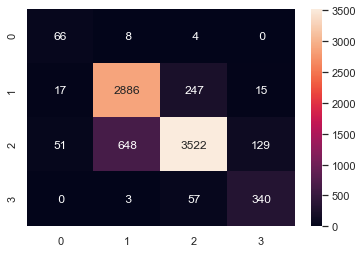

In [21]:
knn = KNeighborsClassifier(n_neighbors=3)
pipeline_knn = imbalanced_make_pipeline(oversample_train, undersample_train, knn)

pipeline_knn.fit(X_train, y_train)
y_pred = pipeline_knn.predict(X_test)
training_score = pipeline_knn.score(X_train,y_train)
test_score = accuracy_score(y_pred, y_test)
print('KNearestNeighbours training score: ', training_score)
print('KNearestNeighbours validation score: ', test_score)


balanced_score = balanced_accuracy_score(y_test, y_pred)
print('KNearestNeighbours balanced accuracy validation score: ', balanced_score)

matrix = confusion_matrix(y_test, y_pred)
sns.heatmap(matrix, annot=True, fmt='2.0f')

In [22]:
models.append('KNearestNeighbours')
acc_training.append(training_score)
acc_test.append(test_score)
acc_balanced.append(balanced_score)

<br>
<center><h3> e - Perceptron </h3></center>

Le <b>Perceptron</b> est un autre algorithme de classification simple adapté à l'apprentissage à <b>grande échelle</b>. Il est sûrement l'un des plus simple <b>ANN</b> (Articial neural network).

Le pereceptron est basé sur un neurone artificiel appelé <b>threshold logic unit</b> (TLU). Les entrées et sorties sont des nombres. 

Chaque connection d'entrée est associé avec un <b>poids</b>. Le <b>TLU</b> une <b>somme</b> de poids des entrées. Puis applique une <b> step function </b> à cette somme et donne en sorties le résultat.

Un seul TLU peut être utilisé pour une <b>simple classification linéaire binaire</b>. Il calcule une <b> combinaison linéaire</b> des entrées et si le résultat dépasse le <b>seuil</b> (threshold de la step function) la sortie (prédiction) sera la <b>classe positive</b> sinon la sortie est la <b>classe négative</b> (comme la Logistic Regression).

Un perceptron est simplement composé de plus d'un <b>seule couche de plusieurs</b> TLU avec chaque TLU connecté à toutes les entrées.

Lorsque tous les neurones dans une couche sont connecté à tout neurone de la couche précédent (neurons d'entrée), la couche est appelé <b>fully connected layer</b>. les entrées du perceptron sont acheminées vers des neurones transitoires spéciaux appelés <b>neurones d'entrée</b>: ils sortent les entrées auxquelles ils sont alimentés.

Si perceptron a 2 entrées et 3 sorties, il peut classifier les instances simultanéments en 3 différentes classes binaire, cela fait du pereceptron un <b>classifier multioutput</b>.

Ce modèle se met à jour <b>uniquement sur les erreurs</b>.

Perceptron training score:  0.3630537831713861
Perceptron validation score:  0.36481921681471285
LinearRegression balanced accuracy validation score:  0.4917149321575086


<AxesSubplot:>

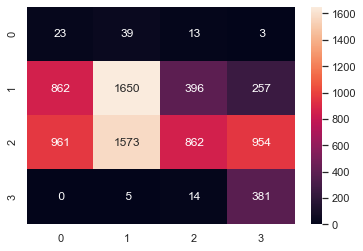

In [25]:
perceptron = Perceptron(tol = 1e-3, random_state = 0)
pipeline_neur = imbalanced_make_pipeline(oversample_train, undersample_train, perceptron)

pipeline_neur.fit(X_train, y_train)
y_pred = pipeline_neur.predict(X_test)
training_score = pipeline_neur.score(X_train,y_train)
test_score = accuracy_score(y_pred, y_test)
print('Perceptron training score: ', training_score)
print('Perceptron validation score: ', test_score)

balanced_score = balanced_accuracy_score(y_test, y_pred)
print('LinearRegression balanced accuracy validation score: ', balanced_score)

matrix = confusion_matrix(y_test, y_pred)
sns.heatmap(matrix, annot=True, fmt='2.0f')

In [26]:
models.append('Perceptron')
acc_training.append(training_score)
acc_test.append(test_score)
acc_balanced.append(balanced_score)

<br>
<center><h3> f - Boosting</h3></center>

Le <b>boosting</b> réfère à tout <b> Ensemble method</b> qui peut <b>transformer</b> plusieurs <b>learners faible</b> en un <b>learner fort</b>. L'idée générale des <b>Boosting methods</b> est d'entrainer des prédicteurs par <b>séquence</b>. Plus précisement, chaque prédicteur essaie de <b>corriger</b> son prédecesseur. (*Ensemble method*: voir annexe ML)

Ici, nous allons utiliser <b>AdaBoost</b> (Adaptive Boosting).

Un moyen pour un nouveau prédicteur de corrier son prédécesseur est d'accorder plus d'attention aux instances d'entraînements que son predecesseur a <b>underfit</b> (sous ajustés). Cela résulte en un nouveau prédicteur concentré de plus en plus sur les <b>cas difficiles</b>. C'est la technique utilisée par <b>Adaboost</b>

AdaBoost with DecisionTree training score:  0.989741023395471
AdaBoost with DecisionTree validation score:  0.9458275991492556
Adaboost balanced accuracy validation score:  0.9139708757087005


<AxesSubplot:>

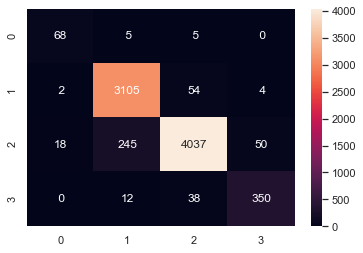

In [27]:
ada_clf = AdaBoostClassifier(DecisionTreeClassifier(), n_estimators=200, algorithm="SAMME.R", learning_rate=0.5)

pipeline_ada = imbalanced_make_pipeline(oversample_train, undersample_train, ada_clf)
pipeline_ada.fit(X_train, y_train)
y_pred = pipeline_ada.predict(X_test)
training_score = pipeline_ada.score(X_train, y_train)
test_score = accuracy_score(y_pred, y_test)
print('AdaBoost with DecisionTree training score: ', training_score)
print('AdaBoost with DecisionTree validation score: ', test_score)


balanced_score = balanced_accuracy_score(y_test, y_pred)
print('Adaboost balanced accuracy validation score: ', balanced_score)

matrix = confusion_matrix(y_test, y_pred)
sns.heatmap(matrix, annot=True, fmt='2.0f')

In [28]:
models.append('Adaboost with DecisionTree')
acc_training.append(training_score)
acc_test.append(test_score)
acc_balanced.append(balanced_score)

<br>
<center><h3> g - Xgboost</h3></center>

<b>XGBoost</b> (Extreme Gradient Boosting) est une implémentation de l'algorithme <b>Gradient Tree Boosting</b> qui est largement reconnu pour son efficacité et sa précision prédictive. <b>Gradient Tree Boosting</b> entraîne un <b>ensemble d'arbre de décision</b> en entraînant chaque arbre à <b>prédire l'erreur de prédiction</b> de tous les arbres précédents de l'ensemble.

XGBoost vise à être <b>très rapide</b>, <b>scalable</b> et <b>portable</b>.

xgboost training score:  0.6997789732682764
xgboost validation score:  0.6969848617540347
Xgboost balanced accuracy validation score:  0.6398025512171002


<AxesSubplot:>

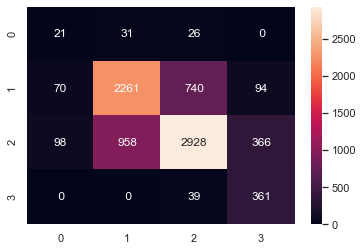

In [30]:
boost = XGBClassifier()
pipeline_xgb = imbalanced_make_pipeline(oversample_train, undersample_train, boost)

pipeline_xgb.fit(X_train, y_train)
y_pred = pipeline_xgb.predict(X_test)

training_score = pipeline_xgb.score(X_train, y_train)
test_score = accuracy_score(y_pred, y_test)
print('xgboost training score: ', training_score)
print('xgboost validation score: ', test_score)

balanced_score = balanced_accuracy_score(y_test, y_pred)
print('Xgboost balanced accuracy validation score: ', balanced_score)

matrix = confusion_matrix(y_test, y_pred)
sns.heatmap(matrix, annot=True, fmt='2.0f')

In [31]:
models.append('xgboost')
acc_training.append(training_score)
acc_test.append(test_score)
acc_balanced.append(balanced_score)

<br>
<center><h3>h - MLP Classification</h3></center>

Un <b>MLP</b> ou (Multi Layers Perceptron) est composé d'une <b>couche d'entrée</b> (input layer), d'<b>une ou plusieurs</b> couche de TLUs (hidden layers) et d'une <b>couche finale</b> de TLUs. Chaque couche (sauf la couche de sortie) comprend un <b>neurons biais</b> (fonction d'activation est en permanence égale à 1) et est **<b>fully connected</b>** à la couche suivante.

Lorsqu'un <b>ANN </b>contient une pile profonde de <b> hidden layers</b> (couche cachée), on appelle ce ANN un <b>DNN</b> (deep neural network). Le domaine du <b>Deep Learning</b> étudie ces DNNs.

In [57]:
from tensorflow import keras

In [58]:
X_train.shape

(71937, 10)

<h4>Création de notre modèle en utilisant l'API <b>Sequential</b> de Keras.</h4>

- La <b>première ligne</b> de code crée un modèle <b>Sequential</b>. C'est le genre de modèle le plus simple dans Keras pour les réseaux de neurones. Ce modèle est composé d'une <b>seule pile</b> de couche </b>connectée séquentiellement</b>.

- Pour ce modèle, nous n'utiliserons pas le resampling comme vu avec <b>SMOTE</b> précédemment, nous allons utiliser la <b>classe weight</b> qui nous permet de gérer les données déséquilibrées également. 

In [59]:
from sklearn.utils import class_weight
class_weight = class_weight.compute_class_weight('balanced',classes=np.unique(y_train.to_numpy()),y= y_train.to_numpy())

In [60]:
model = keras.models.Sequential()
model.add(keras.layers.Flatten(input_shape=[10]))
model.add(keras.layers.Dense(300, activation="relu"))
model.add(keras.layers.Dense(90, activation="relu"))
model.add(keras.layers.Dense(30, activation="relu"))
model.add(keras.layers.Dense(4, activation="softmax"))


- Ensuite dans la <b>seconde ligne</b>, nous construisons la première couche et l'ajoutons au modèle. C'est une couche <b>Flatten</b> dont le rôle est de convertir chaque entrée en un tableau d'une dimension. Cette est couche est seulement là pour faire du preprocessing.

- Nous ajoutons ensuite une couche <b> Dense</b> avec <b> 300 neurons</b>. Cette couche utilise la fonction d'activation <b>ReLU</b>.
    - Chaque couche <b>Dense</b> gère sa propre <b>matrice des poids</b>, contenant toutes les poids de connections entre les neurons et leurs entrées. elle gère aussi un vecteur de biais.
    
    
- Nous ajoutons ensuite deux autres Dense couche (toujours hidden layers).

- Finalement on ajoute  une couche de <b>sortie Dense</b> (output layer) avec 3 (le 4 est exclu) neurones (1 par classe), en utilisant la fonction d'activation <b> softmax</b> car nos classes sont exclusives.



In [61]:
model.compile(loss="sparse_categorical_crossentropy", optimizer="adam",class_weight=class_weight, metrics=["accuracy"])

Avant de fit nos données, on doit compiler notre modèle.
Quelques explications sur le choix des paramètres:

- Nous utilisons <b>sparse_categorical_crossentropy</b> car nous avons des <b>sparse</b> labels (clairsemé) et que chaque classe est <b>exclusive</b>.

- Nous utilisons l'optimiseur <b> adam</b> c'une extension de la <b>descente de gradient stochastique</b>.
    

In [62]:
history = model.fit(X_train, y_train.to_numpy(), epochs=50, validation_data=(X_test, y_test.to_numpy()), verbose=0)

MLP training score 0.99555165
MLP validation score:  0.9971224821719004
MLP balanced accuracy validation score:  0.9827031817667542


<AxesSubplot:>

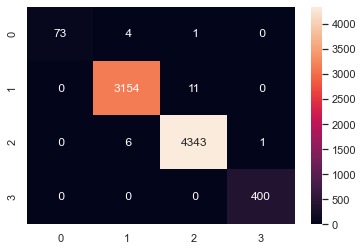

In [63]:
y_pred = model.predict_classes(X_test)

test_score = accuracy_score(y_pred, y_test)
balanced_score = balanced_accuracy_score(y_test, y_pred)

print('MLP training score', max(history.history['accuracy']))
print('MLP validation score: ', test_score)
print('MLP balanced accuracy validation score: ', balanced_score)

models.append('MLP Sequential')
acc_training.append( max(history.history['accuracy']))
acc_test.append(test_score)
acc_balanced.append(balanced_score)

matrix = confusion_matrix(y_test, y_pred)
sns.heatmap(matrix, annot=True, fmt='2.0f')

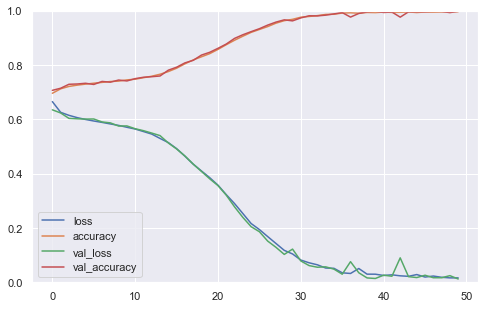

In [64]:
pd.DataFrame(history.history).plot(figsize=(8, 5))
plt.grid(True)
plt.gca().set_ylim(0, 1)
plt.show()

- <b>Train Learning Curve</b> (ici loss & accuracy): courbe d'apprentissage calculée à partir de l'ensemble de données d'entraînement qui donne une idée de la qualité d'apprentissage du modèle.

- <b>Validation Learning Curve</b> (ici val_loss & val_accuracy): courbe d'apprentissage calculée à partir d'un ensemble de données de validation d'attente qui donne une idée de la façon dont le modèle se généralise.

- learning curve montre un <b>sous-ajustement</b> (underfitting) si:

    - La courbe <b>loss training</b> reste stable quelle que soit le training.

    - La courbe <b>loss training</b> continue de diminuer jusqu'à la fin du training.

    - Dans <b>notre cas</b>, on peut voir que nous ne sommes pas dans un cas d'underfitting.
    
 - Les learning curves montre un <b>sur-ajustement</b> (overfitting) si:

    - La courbe <b>loss training</b> continue de diminuer avec l'expérience.
    
    - La courbe <b>loss validation</b>  diminue jusqu'à un certain point et recommence à augmenter.




<br>
<center><h3>i - Quels modèles choisir?</h3></center>

In [45]:

result = pd.DataFrame(data={'model': models, 'training score':acc_training, 'validation score':acc_test,
                            'validation balanced score': acc_balanced})
result



,model,training score,validation score,validation balanced score
0,DecisionTreeClassifier,0.989977,0.939947,0.920562
1,RandomForestClassifier,0.990367,0.945953,0.900410
2,Logistic Regression,0.574836,0.579882,0.515173
3,KNearestNeighbours,0.933622,0.852496,0.854414
4,Perceptron,0.363054,0.364819,0.491715
5,Adaboost with DecisionTree,0.989741,0.945828,0.913971
6,xgboost,0.699779,0.696985,0.639803
7,MLP Sequential,0.994259,0.997373,0.982797


- Le <b>DecisionTreeClassifier</b>, le <b>RandomForestClassifier</b> et <b> Adaboost</b> semble être les plus performants et ceux à tout niveau. Ils sont peut être même trop performant. Pour bien choisir notre modèle, nous devons verifier, qu'il ne tend pas à l'<b>over fitting</b> ou l'<b>under fitting</b>.
    - Les <b>balanced score</b> sont bon, cela veut dire qu'il y a une <b>bonne classification</b> au sein même des classes. Si nous n'avions pas utilisé de méthodes de <b>resampling</b>, cela aurait pu être désastreux.



- Les modèles <b>Perceptron</b>, <b>Logistic Regression</b> et <b>Xgboost</b> sont <b>très peu performants</b> comparés aux autres, on va donc les laisser de côté pour l'instant. Nous y reviendrons si les résultats avec les autres modèles ne sont pas satisfaisant.

Rappel:

- <b>Overfitting</b>: notre modèle correspond trop précisément aux données d'entraînements. Cela peut ne pas correspondre de manière fiable à des données futures.
- <b>Underfitting</b>: notre modèle ne peut ni modéliser les données d'entraînements ni généraliser à de nouvelles données. Cela est facile à détecter, le modèle a de mauvaises performances sur les données d'entraînements. Ce qui n'est pas n'autre cas pour les modèles sélectionnés.

<br>
<center><h1>III - learning curves & cross-validation</h1></center>

Lorsque nous avons commencé le model building, nous aurions pu directement <b>réechantillionner</b> les données, puis ne plus avoir à le faire. C'est en effet une possibilité, mais un moyen de faire <b>faux</b> si l'on utilise la <b>cross validation</b> (chose que nous allos faire).
Le <b>suréchantillonnage</b> de la (ou les) <b>classe minoritaire</b> peut entraîner des problèmes d'<b>overfitting</b> si nous suréchantillonnons avant la <b>cross validation</b>.
L'explication est plutôt longue, je ne la détaillerai pas ici, pour plus d'information à ce sujet, un lien sur un papier qui l'explique très bien se trouve plus bas, en annexe.

Pour bien respecter l'<b>utilisation de la validation croisée</b>  tout en bénéficiant du <b>réechantillonnage</b>, nous allons  réechantillonner <b>durant</b> la validation croisée. Comment? grâce aux <b>pipelines</b> tout simplement.

In [25]:
classifiers = {
    "RandomForest": RandomForestClassifier(),
    "KnearestNeighbours": KNeighborsClassifier(n_neighbors=3),
     "Adaboost":AdaBoostClassifier(DecisionTreeClassifier(), n_estimators=200, algorithm="SAMME.R", learning_rate=0.5),
    "DecisionTreeClassifier": DecisionTreeClassifier()
   
}

<br>
<center><h3>a - Learning curves</h3></center>

Les courbes d'apprentissages peuvent nous aider à choisir notre modèle. Elles peut mettre en évidence si notre modèle overfit ou underfit.
- Notre modèle <b>overfit</b>, si il y a un écart entre le score d'entraînement et le score de la cross-validation. Il y a une <b>grande variance</b>.

- Notre modèle <b>underfit</b>, si le score d'entraînement et de cross validation sont bas. Il y a un <b>grand biais</b>.

In [34]:
from sklearn.model_selection import learning_curve
def plot_learning_curve(estimator, title, X, y, axes=None, ylim=None, cv=None, n_jobs=None, train_sizes=np.linspace(.1, 1.0, 5)):
    sns.set_theme()
    if axes is None:
        _, axes = plt.subplots(1, 1, figsize=(10, 5))

    axes[0].set_title(title)
    if ylim is not None:
        axes[0].set_ylim(*ylim)
    axes[0].set_xlabel("Training examples")
    axes[0].set_ylabel("Score")

    train_sizes, train_scores, test_scores, fit_times, _ = \
        learning_curve(estimator, X, y, cv=cv, n_jobs=n_jobs,
                       train_sizes=train_sizes,
                       return_times=True)
    train_scores_mean = np.mean(train_scores, axis=1)
    train_scores_std = np.std(train_scores, axis=1)
    test_scores_mean = np.mean(test_scores, axis=1)
    test_scores_std = np.std(test_scores, axis=1)
    fit_times_mean = np.mean(fit_times, axis=1)
    fit_times_std = np.std(fit_times, axis=1)
  
    # Plot learning curve
    axes[0].grid()
    axes[0].fill_between(train_sizes, train_scores_mean - train_scores_std,
                         train_scores_mean + train_scores_std, alpha=0.1,
                         color="r")
    axes[0].fill_between(train_sizes, test_scores_mean - test_scores_std,
                         test_scores_mean + test_scores_std, alpha=0.1,
                         color="g")
    axes[0].plot(train_sizes, train_scores_mean, 'o-', color="r",
                 label="Training score")
    axes[0].plot(train_sizes, test_scores_mean, 'o-', color="g",
                 label="Cross-validation score")
    axes[0].legend(loc="best")

    return plt

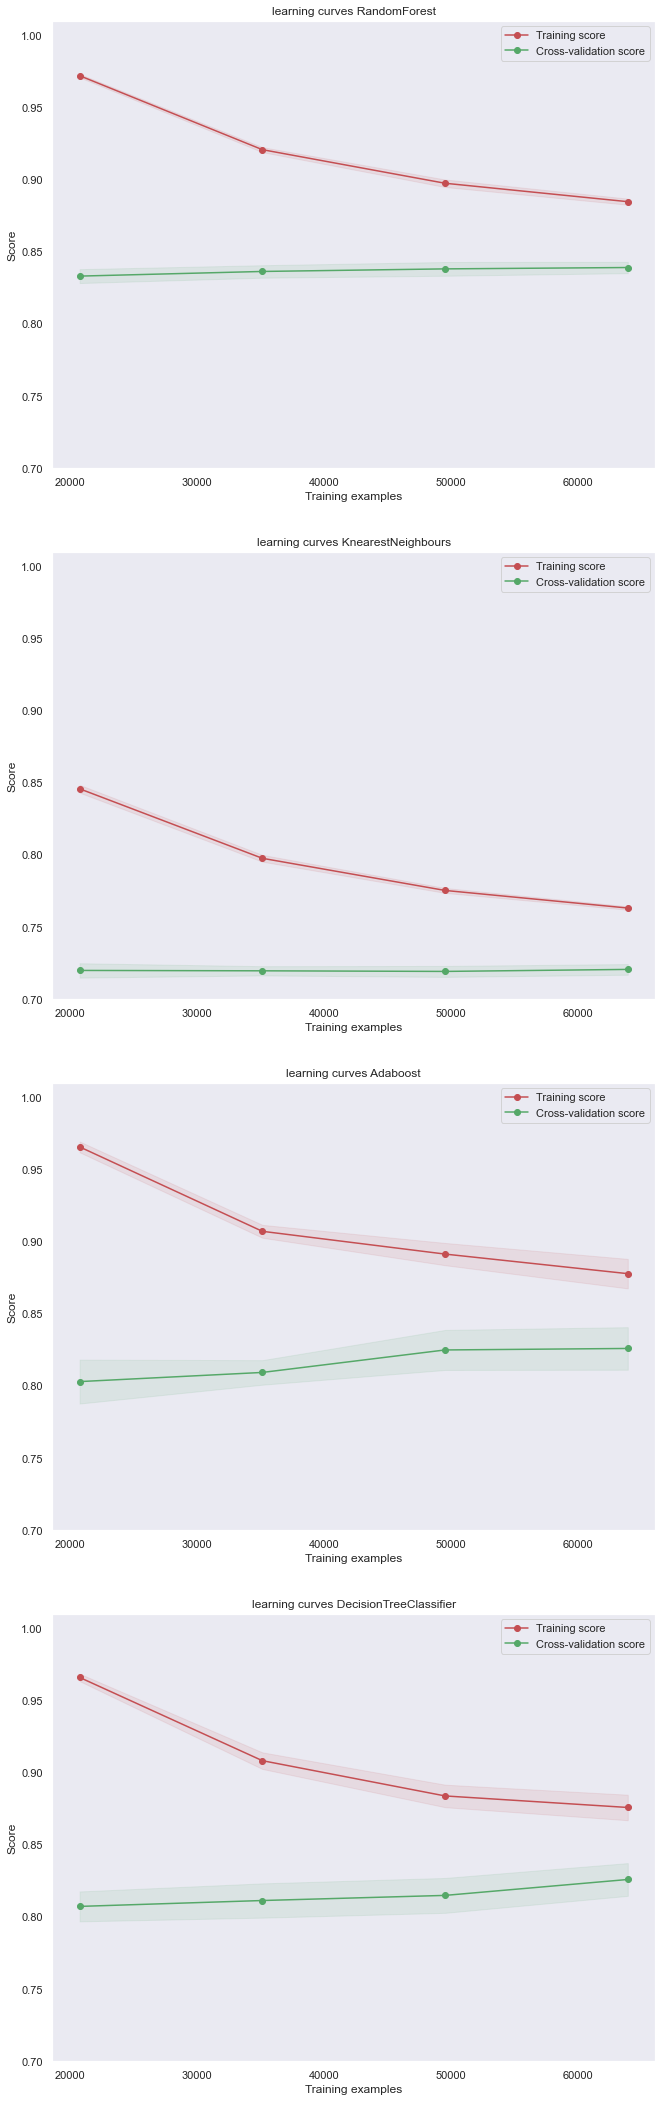

In [37]:
from sklearn.model_selection import ShuffleSplit
i_ax = 0

sns.set_theme()
fig, axes = plt.subplots(len(classifiers), 1, figsize=(10, 30), squeeze=False)

for key, classifier in classifiers.items():
    
    title = 'learning curves ' + key
# Cross validation with 100 iterations to get smoother mean test and train
# score curves, each time with 20% data randomly selected as a validation set.
    pipeline_clf = imbalanced_make_pipeline(oversample_train_origin, undersample_train_origin, classifier)
    cv = ShuffleSplit(n_splits=10, test_size=0.2, random_state=0)
    plot_learning_curve(pipeline_clf, title, X_train_origin, y_train_origin, axes=axes[i_ax], ylim=(0.7, 1.01), cv=cv, n_jobs=4)
    
    i_ax += 1
fig.tight_layout(pad=3.0)


<br>
<center><h3> b - Cross-validation, scoring: <b>balanced accuracy</b></h3></center>

In [47]:
from sklearn.model_selection import RepeatedStratifiedKFold

In [48]:

model_name = []
acc_mean = []
acc_std = []

for key, classifier in classifiers.items():
    
    pipeline_clf = imbalanced_make_pipeline(oversample_train_origin, undersample_train_origin, classifier)
    cv = RepeatedStratifiedKFold(n_splits=10, n_repeats=3, random_state=1)
    scores = cross_val_score(pipeline_clf, X_train_origin, y_train_origin, scoring='balanced_accuracy', cv=cv, n_jobs=-1)
    
    model_name.append(key)
    acc_mean.append(np.mean(scores))
    acc_std.append(np.std(scores))

In [50]:
result = pd.DataFrame({'model': model_name, 'balanced accuracy mean': acc_mean, 'balanced accuracy std': acc_std})
  
result

,model,balanced accuracy mean,balanced accuracy std
0,RandomForest,0.893076,0.010425
1,KnearestNeighbours,0.829622,0.010966
2,Adaboost,0.895015,0.012215
3,DecisionTreeClassifier,0.891846,0.012985


Le <b>DecisionTreeClassifier</b>, le <b>RandomForest</b> et l'<b>Adaboost</b> (basé sur un decision tree) sont clairement en train d'<b>overfit</b>, l'écart entre la courbe d'entraînement et la courbe de cross-validation est grand. Cependant, plus le nombre d'exemple est grand, plus l'écart se réduit. Pour résoudre un problème d'overfitting on peut:

- Pour n'importe quel algorithme, <b>augmenter</b> la tailler des données peut aider à résoudre l'overfitting.

- Pour une <b>Random Forest</b> on peut:
    - <b>Augmenter le nombre d'estimateur</b>, plus il y a d'arbres, moins l'algorithme est susceptible d'overfit.
    - <b>Ajuster la profondeur maximale</b>, ce paramètre réduira la complexité des modèles appris, diminuant ainsi le risque d'overfitting.
    
    

- Pour un <b>Decision Tree</b> on peut:

    - <b>"Pré-tailler" l'arbre</b>, ce qui arrête la croissance de l'arbre plus tôt, avant de classer parfaitement l'ensemble d'entraînement.
    - <b>"Post-élagager" l'arbre</b>, ce qui permet à l'arbre de classer parfaitement l'ensemble d'entraînement, puis post-élaguer l'arbre.
    - Comme le précise la documentation de sklearn sur les arbres de décision:
    > The default values for the parameters controlling the size of the trees (e.g. max_depth, min_samples_leaf, etc.) lead to fully grown and <b>unpruned</b> trees which can potentially be very large on some data sets. To reduce memory consumption, the complexity and size of the trees should be controlled by setting those parameter values.
    
    
    
    
- Pour notre algorithme <b>Adaboost</b>, il est basé sur un arbre de décision, fixer un décision tree avec les <b>conditions précédentes</b> semble donc être une bonne idée.

- <b>Xgboost</b>, a un score d'entraînement très proche de celui de validation, on peut donc estimer qu'il n'y a pas d'overfitting dans son cas.


    

<br>
<center><h1> IV - Fine tuning models </h1></center>

Précédement, nous avons attribué des valeurs aux paramètres de nos modèles, bien que l'on a essayé de mettre des valeurs cohérentes, il se peut que ces valeurs ne soient pas les valeurs <b>optimales</b>.

Pour se rapprocher des valeurs optimales on va faire du <b>fine tuning</b> en utilisant <b>GridSearcgCV</b>. Il va s'occuper de tester une multitude de combinaisons de paramètres qu'on lui aura fourni. Il gardera ainsi la <b>meilleure combinaison</b>.

On va prendre maintenant seulement les modèles les plus performants selon nos critères (accuracy & generalization) car cela demande beaucoup de temps de calcul pour chercher la bonne combinaison pour chaque modèle.

In [58]:
from sklearn.model_selection import GridSearchCV
models_tune = []
best_scores = []

In [ ]:
def tuning(classifier, params, X, y):
    len_1999, len_2000, len_2001, len_2002 = over_undersample(X, valid=True)
    pipeline_clf = imbalanced_make_pipeline(SMOTE(), RandomUnderSampler(), classifier)
    
    params['smote__sampling_strategy']= [{0:len_1999, 3:len_2002}]
    params['randomundersampler__sampling_strategy']=[{1:len_2000, 2:len_2001}] 
    
    grid_clf = GridSearchCV(estimator = pipeline_clf, param_grid = params, scoring='balanced_accuracy' )
    grid_clf.fit(X, y)
    
    return grid_clf

<br>

- <b>Random Forest</b>

In [79]:
params = {'randomforestclassifier__bootstrap':[False,True],'randomforestclassifier__n_estimators':[150],'randomforestclassifier__max_depth':[17],
               'randomforestclassifier__max_features':['auto','sqrt','log2']}
grid_rf = tuning(RandomForestClassifier(), params, X_train_origin, y_train_origin)

print(grid_rf.best_estimator_)
print(grid_rf.best_score_)

models_tune.append("Random Forest")
best_scores.append(grid_rf.best_score_)

Pipeline(steps=[('smote', SMOTE(sampling_strategy={0: 7993, 3: 7993})),
                ('randomundersampler',
                 RandomUnderSampler(sampling_strategy={1: 15986, 2: 15986})),
                ('randomforestclassifier',
                 RandomForestClassifier(bootstrap=False, max_depth=17,
                                        max_features='log2',
                                        n_estimators=150))])
0.8282104163532275


<br>

- <b>Decision Tree

In [92]:
params = {'decisiontreeclassifier__criterion':['gini','entropy'],'decisiontreeclassifier__splitter':['best', 'random'],'decisiontreeclassifier__max_depth':range(5,25),
               'decisiontreeclassifier__max_features':['auto','sqrt','log2']}

grid_dc = tuning(DecisionTreeClassifier(),params , X_train_origin, y_train_origin )

print(grid_dc.best_estimator_)
print(grid_dc.best_score_)

models_tune.append("Decision Tree")
best_scores.append(grid_dc.best_score_)

Pipeline(steps=[('smote', SMOTE(sampling_strategy={0: 7993, 3: 7993})),
                ('randomundersampler',
                 RandomUnderSampler(sampling_strategy={1: 15986, 2: 15986})),
                ('decisiontreeclassifier',
                 DecisionTreeClassifier(criterion='entropy', max_depth=14,
                                        max_features='sqrt'))])
0.705494177833795


<br>

- <b>Adaboost</b>

In [93]:
dtc = DecisionTreeClassifier(max_depth = 14, max_features='sqrt')
abc = AdaBoostClassifier(dtc)
grid_abc = tuning(abc, {"adaboostclassifier__base_estimator__criterion" : ["gini", "entropy"],
              "adaboostclassifier__base_estimator__splitter" :   ["best", "random"],
              "adaboostclassifier__n_estimators": range(20,200,30), "adaboostclassifier__algorithm": ["SAMME.R"], "adaboostclassifier__learning_rate":[0.5]
             }, X_train_origin, y_train_origin)

print(grid_abc.best_estimator_)
print(grid_abc.best_score_)

models_tune.append("Adaboost")
best_scores.append(grid_abc.best_score_)

Pipeline(steps=[('smote', SMOTE(sampling_strategy={0: 7993, 3: 7993})),
                ('randomundersampler',
                 RandomUnderSampler(sampling_strategy={1: 15986, 2: 15986})),
                ('adaboostclassifier',
                 AdaBoostClassifier(base_estimator=DecisionTreeClassifier(criterion='entropy',
                                                                          max_depth=14,
                                                                          max_features='sqrt',
                                                                          splitter='random'),
                                    learning_rate=0.5, n_estimators=170))])
0.9275112769308471


<br>

- <b>KNN</b>

In [95]:
knn = KNeighborsClassifier()
params = {'kneighborsclassifier__n_neighbors':range(2,10), 'kneighborsclassifier__weights':['uniform', 'distance'],
          'kneighborsclassifier__metric':['euclidean', 'manhattan']}

grid_knn = tuning(knn, params, X_train_origin, y_train_origin)

print(grid_knn.best_estimator_)
print(grid_knn.best_score_)

models_tune.append("KNN")
best_scores.append(grid_knn.best_score_)

Pipeline(steps=[('smote', SMOTE(sampling_strategy={0: 7993, 3: 7993})),
                ('randomundersampler',
                 RandomUnderSampler(sampling_strategy={1: 15986, 2: 15986})),
                ('kneighborsclassifier',
                 KNeighborsClassifier(metric='manhattan', n_neighbors=7,
                                      weights='distance'))])
0.8764371672187407


<br>
Regardons les résultats après fine tuning.

In [96]:
result = pd.DataFrame(data={'model':models_tune, "best_score":best_scores})
result

,model,best_score
0,Random Forest,0.825793
1,Random Forest,0.828210
2,Decision Tree,0.705494
3,Adaboost,0.927511
4,KNN,0.876437


Après l'étape de <b>fine tuning</b>, il semblerait que les modèles <b>RandomForest</b> et <b>KNN</b> sont largement dépassé par <b>Adaboost</b>. Cependant, ce n'est pas encore fini, s'il ne sont pas assez performant seul, peut être qu'<b>ensemble</b> ils peuvent rester dans la course.

C'est au tour du <b>VotingClassifier</b> de faire son apparition. Le VotingClassifier est une méthode de <b>Bagging</b>.
Ce Classifier permet d'utiliser plusieurs modèles à la fois.

In [51]:
from sklearn.ensemble import VotingClassifier
models = []
acc_train = []
acc_test = []
acc_balanced = []

In [52]:
knn = KNeighborsClassifier(metric='manhattan', n_neighbors=7,
                                      weights='distance')
rfc = RandomForestClassifier(bootstrap=False, max_depth=17,
                                        max_features='log2',
                                        n_estimators=150)

voting_clf = VotingClassifier(estimators=[('rfc', rfc), ('knn', knn)], voting='soft')

pipeline_clf = imbalanced_make_pipeline(oversample_train, undersample_train, voting_clf)
    
pipeline_clf.fit(X_train, y_train)
score_vot = pipeline_clf.score(X_train, y_train)
y_vot = pipeline_clf.predict(X_test)

models.append('Voting')
acc_train.append(score_vot)
acc_test.append(accuracy_score(y_vot, y_test))
acc_balanced.append(balanced_accuracy_score(y_vot, y_test))

In [53]:
pipeline_knn = imbalanced_make_pipeline(oversample_train, undersample_train, knn)
pipeline_rfc = imbalanced_make_pipeline(oversample_train, undersample_train, rfc)

pipeline_knn.fit(X_train, y_train)
pipeline_rfc.fit(X_train, y_train)

score_knn = pipeline_knn.score(X_train, y_train)
score_rfc = pipeline_rfc.score(X_train, y_train)

#validation
y_knn = pipeline_knn.predict(X_test)
y_rfc = pipeline_rfc.predict(X_test)

models.append('KNN')
acc_train.append(score_knn)
acc_test.append(accuracy_score(y_knn, y_test))
acc_balanced.append(balanced_accuracy_score(y_knn, y_test))

models.append('Random Forest')
acc_train.append(score_rfc)
acc_test.append(accuracy_score(y_rfc, y_test))
acc_balanced.append(balanced_accuracy_score(y_rfc, y_test))



In [54]:
result = pd.DataFrame({'model':models, 'acc train':acc_train, 'acc validation':acc_test, 'acc balanced':acc_balanced})
result

,model,acc train,acc validation,acc balanced
0,Voting,0.986155,0.934192,0.882852
1,KNN,0.985654,0.928813,0.840607
2,Random Forest,0.911200,0.867634,0.850187


Super le <b>VotingClassifier</b> surpasse le Random Forest et Le KNN dans toutes nos mesures. Cependant, on peut remarquer qu'il y a toujours un overfitting (acc train >> acc validation).

<br>
<h4> Toujours over-fitting?</h4>
Certains de nos modèles avaient des problèmes d'<b>overfitting</b>. Est ce qu'après le <b>fine tuning</b> le problème est-il reglé?

In [65]:
models_tunes = {"Adaboost":AdaBoostClassifier(base_estimator=DecisionTreeClassifier(criterion='entropy',
                                                                          max_depth=14,
                                                                          max_features='sqrt',
                                                                          splitter='random'),
                                    learning_rate=0.5, n_estimators=170),
                "VotingClassifier":voting_clf}
name_model = []
acc_train = []
acc_valid = []
acc_balanced = []

for key, value in models_tunes.items():
    name_model.append(key)
    pipeline = imbalanced_make_pipeline(oversample_train, undersample_train, value)
    pipeline.fit(X_train, y_train)
    acc_train.append(pipeline.score(X_train, y_train))
    
    y_pred = pipeline.predict(X_test)
    acc_valid.append(accuracy_score(y_pred, y_test))
    acc_balanced.append(balanced_accuracy_score(y_pred, y_test))

In [66]:
models_tunes["MLP"] = model
name_model.append("Sequential MLP")
acc_train.append(model.history.history['accuracy'][-1])
y_pred = model.predict_classes(X_test)
acc_valid.append(accuracy_score(y_pred, y_test))
acc_balanced.append(balanced_accuracy_score(y_pred, y_test))


result_validation = pd.DataFrame(data={'model': name_model, 'training score': acc_train,  'validation score': acc_valid,
                                       'balanced validation score': acc_balanced
                                         })
result_validation

,model,training score,validation score,balanced validation score
0,Adaboost,0.997442,0.981859,0.971922
1,VotingClassifier,0.987489,0.934818,0.889968
2,Sequential MLP,0.883202,0.997122,0.997898


- Le modèle <b>Voting Classifier</b> <b>sur-ajuste</b> (overfit) grandement les données. On va donc s'en passé, il ne <b>généralise</b> pas assez bien les données. De plus, son score sur au sein des classes est largement inférieur aux deux autres.

- Le modèle <b>Adaboost</b> à de très bonne performance, il <b>overfit très légèrement</b> les données. Il a un score au sein des classes <b>très satisfaisant</b>.

- Le modèle <b> Sequential MLP</b> semble être le <b>plus performant</b>. Cependant son score d'entraînement est <b>légèrement inférieur</b> au score de validation, il underfit un peu les données.

Notre choix va donc se faire entre ces deux modèles, <b>Adaboost</b> et le <b>Sequential MLP</b>.

<center><h2>VI - Final test</h2></center>

Lorsque nous avons séparer nos données, nous avons laissé de côté un petit data set: le <b>final test set</b>. Il nous servira donc à tester nos deux modèles une dernière fois.

In [70]:
import time
accuracies = []
balanced_accuracies = []
train_time = []
predict_time = []

<center><h3>Adaboost</h3></center>

ADABOOST CLASSIFIER:
accuracy on final test:  0.9833358354601411
balanced accuracy on final test:  0.9830778828580834


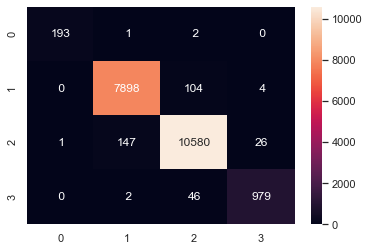

In [71]:
ada = AdaBoostClassifier(base_estimator=DecisionTreeClassifier(criterion='entropy',
                                                                          max_depth=14,
                                                                          max_features='sqrt',
                                                                          splitter='random'),
                                    learning_rate=0.5, n_estimators=170)

len_1999, len_2000, len_2001, len_2002 = over_undersample(X_train_origin)
oversample_train = SMOTE(sampling_strategy={0:len_1999,3:len_2002})
undersample_train = RandomUnderSampler(sampling_strategy={1:len_2000,2:len_2001})


pipeline = imbalanced_make_pipeline(oversample_train, undersample_train, ada)

####### Fit Train Set + Measure Time #######
start = time.time()
pipeline.fit(X_train_origin, y_train_origin)
stop = time.time()
train_time.append(stop-start)

###### Predict Final Test Set + Measure Time ######
start = time.time()
y_pred_ada = pipeline.predict(X_final_test)
stop = time.time()
predict_time.append(stop-start)

########### accuracy metrics###########
print('ADABOOST CLASSIFIER:')
print('accuracy on final test: ', accuracy_score(y_pred_ada, y_final_test))
print('balanced accuracy on final test: ', balanced_accuracy_score(y_pred_ada, y_final_test))

accuracies.append(accuracy_score(y_pred_ada, y_final_test))
balanced_accuracies.append(balanced_accuracy_score(y_pred_ada, y_final_test))

matrix_ada = confusion_matrix(y_final_test, y_pred_ada)

sns.heatmap(matrix_ada, annot=True, fmt='2.0f')
plt.show()

<center><h3>Sequential MLP</h3></center>

SEQUENTIAL MLP CLASSIFIER: 
MLP validation score:  0.9986488515237952
MLP balanced accuracy validation score:  0.9993492411023235


<AxesSubplot:>

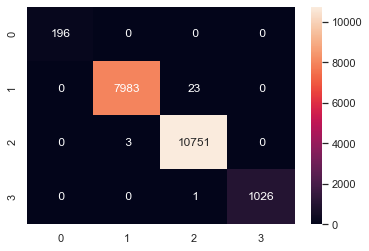

In [72]:
class_weight = class_weight.compute_class_weight('balanced',classes=np.unique(y_train.to_numpy()),y= y_train.to_numpy())
model = keras.models.Sequential()
model.add(keras.layers.Flatten(input_shape=[10]))
model.add(keras.layers.Dense(300, activation="relu"))
model.add(keras.layers.Dense(90, activation="relu"))
model.add(keras.layers.Dense(30, activation="relu"))
model.add(keras.layers.Dense(4, activation="softmax"))
model.compile(loss="sparse_categorical_crossentropy", optimizer="adam",class_weight=class_weight, metrics=["accuracy"])

######### Fit Train Set + Time Measure ############
start = time.time()
model.fit(X_train_origin, y_train_origin.to_numpy(), epochs=50, validation_data=(X_test, y_test.to_numpy()), verbose=0)
stop = time.time()
train_time.append(stop-start)

######## Predict Final Test Set + Time Measure ########
start = time.time()
y_pred_mlp = model.predict_classes(X_final_test)
stop = time.time()
predict_time.append(stop-start)

########### accuracy metrics###########
test_score = accuracy_score(y_pred_mlp, y_final_test)
balanced_score = balanced_accuracy_score(y_pred_mlp, y_final_test)

accuracies.append(test_score)
balanced_accuracies.append(balanced_score)

print('SEQUENTIAL MLP CLASSIFIER: ')
print('MLP validation score: ', test_score)
print('MLP balanced accuracy validation score: ', balanced_score)

matrix = confusion_matrix(y_final_test, y_pred_mlp)
sns.heatmap(matrix, annot=True, fmt='2.0f')

On peut observer que le <b>Sequential MLP Classifier</b>  est plus performant que l'<b>AdaBoost Classifier</b>  sur l'<b>accuracy classique</b> mais également sur la <b>balanced accuracy</b>. Cela signifie que le  MLP Classifier  est plus performant sur la <b>classification générale</b> mais aussi sur la <b>classification au sein des classes</b>.


In [74]:
result = pd.DataFrame({'Model':['Adaboost', 'Sequential MLP'], 'Accuracy':accuracies,
                       'Balanced accuracy':balanced_accuracies, 'Time training measure':train_time, 
                       'Time test measure':predict_time
    
})
result

,Model,Accuracy,Balanced accuracy,Time training measure,Time test measure
0,Adaboost,0.983336,0.983078,13.086756,0.799937
1,Sequential MLP,0.998649,0.999349,559.519064,1.230662


<br>
<h3>Finalement, quel modèle choisir?</h3>

Si l'on se fit aux metrics d'<b>accuracy</b> que nous avons utilisé, dans tous les cas, le <b>Sequential MLP</b> est LE modèle à choisir. Cependant, généralement lorsqu'on choisit un modèle, il peut y avoir d'<b>autres critères</b> qui peuvent rentrer en compte.
Nous allons en expliquer un rapidement, pour cela il faut comprendre le concept de <b>Batch Learning</b> & celui de <b>Online Learning</b>.

<center><h3>Batch Learning vs Online Learning</h3></center>

un critère utilisé pour classer les systèmes d'apprentissage machine est de savoir si le système peut ou non apprendre de manière <b>incrémentielle</b> à partir d'un flux de données <b>entrant</b>.

- <b> Batch learning </b>

Dans le <b>batch learning</b>, le système est <b>incapable</b> d'apprendre <b>progressivement</b> : il doit être formé en utilisant toutes les données <b>disponibles</b>. Cela prend généralement beaucoup de <b>temps</b> et beaucoup de <b>ressources de calcul</b>, ce genre de système est donc fait généralement <b>"offline"</b>.

<b>Premièrement</b>, le modèle (système) est <b>entrainé</b>, et <b>ensuite</b> il est lancé en <b>production</b> et <b>tourne</b> sans plus <b>jamais</b> apprendre. Il applique seulement ce qu'il a appris. C'est ce que l'on appelle le <b>offline learning</b>.

<br>

- <b>Online Learning</b>

Dans le <b>online learning</b>, on entraine le système <b>incrémentiellement</b> en lui donnant les <b>instances de données</b> de manière <b>séquentielle</b>, soit <b>individuellement</b>, soit en <b>petits groupes</b> appelés <b>mini-batchs</b>. Chaque étape est <b>rapide</b> et <b>peu couteuse</b>, donc le système peut apprendre de <b>nouvelles</b> données au <b>fur et à mesure</b>.

Si l'on se réfère à nos <b>derniers résultats</b> sur nos deux classifiers, on peut remarque une différence colossale sur le temps d'entraînement. Le <b>classifier Adaboost</b> à un temps d'entraînement, plus de <b>40 fois plus rapide</b> que le <b>Sequential MLP</b>.

Pour finir, nous pouvons revenir à ce que nous disions au tout début, il n'existe pas de <b>meilleur modèle</b> qu'un notre, cela <b>dépend de nombreux critères</b> tel que nos <b>objectifs</b>, nos <b>moyens</b> et bien d'autres.

- Si nous cherchons absolument la <b>précision</b> sans se soucier du temps de calcul, nous choisirons le classifier <b>Sequential MLP</b>.

- Si nous ne cherchons pas absolument la précision et que l'on se soucie du <b>temps de calcul</b> nous choisirons le classifier <b>Adaboost</b>, qui de plus reste très proche du score de précision de Sequential MLP.

<br>
sources:

- sklearn <b>SVM complexity</b>: https://scikit-learn.org/stable/modules/svm.html#complexity


- sklearn <b>DecisionTree</b>:
    - https://scikit-learn.org/stable/modules/generated/sklearn.tree.DecisionTreeClassifier.html
    - https://scikit-learn.org/stable/modules/tree.html#tree
    
    
- <b> Learning curves</b>:
    - https://machinelearningmastery.com/learning-curves-for-diagnosing-machine-learning-model-performance/
    - https://scikit-learn.org/stable/auto_examples/model_selection/plot_learning_curve.html#sphx-glr-auto-examples-model-selection-plot-learning-curve-py
    
    
- <b>Balanced accuracy</b>:
    - https://scikit-learn.org/stable/modules/model_evaluation.html
    
    
- <b> Handle Imbalanced dataset with SMOTE</b>:
    - https://machinelearningmastery.com/multi-class-imbalanced-classification/
    - https://machinelearningmastery.com/smote-oversampling-for-imbalanced-classification/
    - https://arxiv.org/abs/1106.1813
    - <b>resampling during cross-validation</b>:
         - https://www.marcoaltini.com/blog/dealing-with-imbalanced-data-undersampling-oversampling-and-proper-cross-validation
         - https://www.kaggle.com/janiobachmann/credit-fraud-dealing-with-imbalanced-datasets
    
    
- <b>Ensemble</b> methods :
    - Machine Learning with scikit-learn, Keras & TensorFlow de Aurélien Géron.
            
            
- <b>Bagging</b> methods:
    - https://scikit-learn.org/stable/modules/ensemble.html#forest
    - Hands on Machine Learning with scikit-learn, Keras & TensorFlow p 189 de Aurélien Géron.
    
    
- <b>Hyperparamètres</b>:
    - https://scikit-learn.org/stable/modules/grid_search.html
    - Hands on Machine Learning with scikit-learn, Keras & TensorFlow p 31 de Aurélien Géron.



- <b>batch learning vs onlinelearning:</b>
    - Hands on Machine Learning with scikit-learn, Keras & TensorFlow p 14 de Aurélien Géron.